# Preprocess Training Data

In this notebook, we will perform several preprocessing method to clean the data. We focus mainly on the missing values. All the functions in this notebook are migrated to preprocess_train.py

## 1. Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
%matplotlib inline

In [20]:
plt.style.use("seaborn")

## 2. Get Data

In [22]:
df = pd.read_csv("_database/Input/train.csv", index_col = 0) # read the data

Create get instruction function to extract info for each column

In [23]:
def get_instruction(label):
    
    col_names = df.columns
    
    
    # input check
    if (not label in col_names) | (label == "SalePrice"):
        print("Error, column name not specified!")
        return 
    
    # specifying the next column name
    next_label = col_names[int([i+1 for i, val in enumerate(col_names) if val == label][0])]
    
    # compile using re
    label = re.compile("^{}:".format(label))
    next_label = re.compile("^{}:".format(next_label))

    # algorithm start
    with open("_database/Input/data_description.txt") as desc:
        finish = False
        while True:
            if finish:
                break
                
            line = desc.readline()

            if label.search(line):
                print(line, end = "")

                while True:
                    line = desc.readline()
                    if next_label.search(line):
                        finish = True
                        break
                    elif line == "":
                        finish = True
                        break
                    else:
                        print(line, end = "")
                    
    return 

View the data

In [24]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [25]:
print(df.shape)

(1460, 80)


In [26]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Number of type

In [30]:
np.sum(df.dtypes == "int64")

34

In [31]:
np.sum(df.dtypes == "object")

43

In [32]:
np.sum(df.dtypes == "float64")

3

## 3. Handling Missing Values

Number of missing values each variables

In [33]:
def var_missing():
    missing_values = df.isna().apply(sum)[df.isna().apply(sum) > 0].sort_values()
    return pd.DataFrame({"Missing": missing_values})

In [34]:
var_missing()

,Missing
Electrical,1
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtFinType1,37
BsmtExposure,38
BsmtFinType2,38
GarageCond,81
GarageQual,81


In [36]:
def plot_missing():
    missing_values = var_missing()
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(missing_values.index, missing_values["Missing"])
    _ = plt.xticks(rotation = 90)
    ax.set_title("Missing values")

/Users/kelvinchristian/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


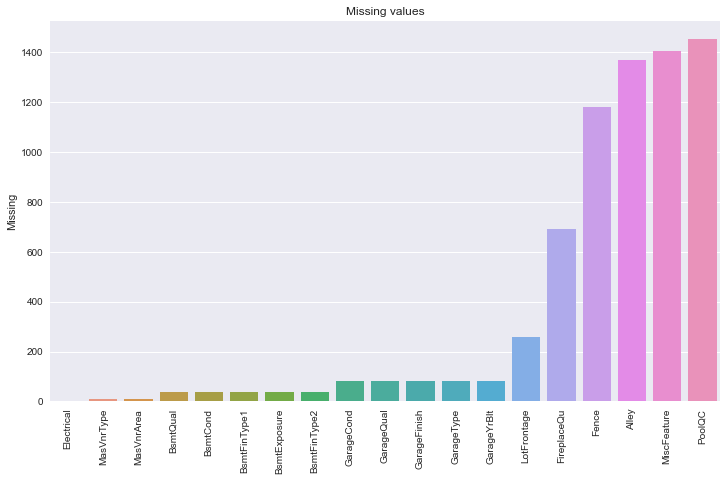

In [38]:
plot_missing()

We have to handle missing value for each column manually since we want to get the best score on kaggle

##### Electrical 

In [43]:
get_instruction("Electrical")

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
		


Since electrical variable only has 1 missing value, we can use the most frequent category

In [44]:
df["Electrical"].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [45]:
df = df.loc[df["Electrical"].isna() == False,:]

In [46]:
df.shape

(1459, 80)

##### Garage

In [47]:
var_missing()

,Missing
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtFinType1,37
BsmtFinType2,38
BsmtExposure,38
GarageCond,81
GarageQual,81
GarageFinish,81


Now, we're looking for the garage variables, it shows that 81 of the obervations have NaN values on garage variables, one might guess that there are 81 houses that don't have garage, we can also check if all garage variables are NaN.

In [48]:
garage = list(df.columns[["Garage" in col for col in df.columns]]) # find garage columns
print(garage)

['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']


In [49]:
df.loc[df["GarageType"].isna(),garage]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
Id,,,,,,,
40,NaN,NaN,NaN,0,0,NaN,NaN
49,NaN,NaN,NaN,0,0,NaN,NaN
79,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
90,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...
1350,NaN,NaN,NaN,0,0,NaN,NaN
1408,NaN,NaN,NaN,0,0,NaN,NaN
1450,NaN,NaN,NaN,0,0,NaN,NaN


In [50]:
# View instruction of garage variables
for variab in garage:
    get_instruction(variab)

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		


In [51]:
df["GarageType"].value_counts()

Attchd     870
Detchd     387
BuiltIn     87
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

Here, we see that NA value in variable "garage" means that the house doesn't have garage (not a missing values), but pandas think that it has a missing values. We can fix this problem by fill na.

In [52]:
df.loc[df["GarageYrBlt"].isna(),"GarageYrBlt"] = 0

In [53]:
df.loc[df["GarageType"].isna(), ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]] = "NA"

In [54]:
df["GarageType"].value_counts()

Attchd     870
Detchd     387
BuiltIn     87
NA          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

##### Basement

In [55]:
var_missing()

,Missing
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtFinType1,37
BsmtExposure,38
BsmtFinType2,38
LotFrontage,259
FireplaceQu,689
Fence,1178


In [56]:
basement = list(df.columns[["Bsmt" in col for col in df.columns]]) # find basement columns
print(basement)

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']


In [57]:
df.loc[df[basement[0]].isna(),basement].head(10) # view the basement variables with missing values

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
18,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
40,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
91,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
103,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
157,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
183,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
260,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
343,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
363,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0


In [58]:
for col in basement:
    get_instruction(col)

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinS

Again, NA on basement variables are not missing values, we can also see that the observation that has NA on one of the basement variable is also NA on the other basement variables. However, we have another problem, there are 37 NA values in BsmtQual and 38 NA values in BsmtExposure and BsmtFinType2

In [59]:
# find NaN on BsmtExposure but not on BsmtQual
falacy_1 = (df["BsmtQual"].isna() == False) & (df["BsmtExposure"].isna())
df.loc[falacy_1,basement]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
949,Gd,TA,NaN,Unf,0,Unf,0,936,936,0,0


In [60]:
# find NaN on BsmtFinType2 but not on BsmtQual
falacy_2 = (df["BsmtQual"].isna() == False) & (df["BsmtFinType2"].isna())
df.loc[falacy_2,basement]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
333,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,1,0


Since NA means no basement, These two observations are wrong. BmstQual says that the basement is good but BsmtExposure says no basement on falacy 1 and BmstFinType2 says no basement on falacy 2. One solution is to use most frequent values for these observations since there are only 2 observations

In [61]:
df["BsmtExposure"].value_counts()

No    952
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [62]:
df["BsmtFinType2"].value_counts()

Unf    1255
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [63]:
df.loc[falacy_1, "BsmtExposure"] = "No"
df.loc[falacy_2, "BsmtFinType2"] = "Unf"

Then we can change NaN values of the basement variables by string "NA"

In [64]:
df["BsmtQual"].value_counts()

TA    649
Gd    617
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [65]:
df.loc[df["BsmtQual"].isna(), ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]] = "NA"

In [66]:
df["BsmtQual"].value_counts()

TA    649
Gd    617
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64

In [67]:
df.shape

(1459, 80)

##### Alley and Fireplace

In [68]:
var_missing()

,Missing
MasVnrType,8
MasVnrArea,8
LotFrontage,259
FireplaceQu,689
Fence,1178
Alley,1368
MiscFeature,1405
PoolQC,1452


In [69]:
variable_na = ["Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]

In [70]:
for variab in variable_na:
#     get_instruction(variab)
#     print("Value count before : ")
#     print(df[variab].value_counts())
#     print()
#     print("Fill missing values with NA")
    df.loc[df[variab].isna(),variab] = df.loc[df[variab].isna(),variab].fillna("NA")
#     print()
#     print("Value count after : ")
#     print(df[variab].value_counts())

In [71]:
var_missing()

,Missing
MasVnrType,8
MasVnrArea,8
LotFrontage,259


In [72]:
df.shape

(1459, 80)

### Last part

From here, the last 3 variables that have NaN can be treated arbitrarily. Here I use mean imputation for the Lot Frontage and MasVnrArea and make new category NA for MasVnrType

In [73]:
df.loc[df["LotFrontage"].isna(), "LotFrontage"] = df["LotFrontage"].mean()

In [74]:
df.loc[df["MasVnrArea"].isna(), "MasVnrArea"] = 0

In [75]:
df.loc[df["MasVnrType"].isna(), "MasVnrType"] = "NA"

In [76]:
var_missing()

,Missing


No more missing value problem

## 4. Change data type

In [77]:
type_cols = ["category", "category", "float64", "int64", "category", "category", "category", "category",
             "category", "category", "category", "category", "category", "category", "category", "category",
             "category", "category", "int64", "int64", "category", "category", "category", "category",
            "category", "float64", "category", "category", "category", "category", "category", "category",
            "category", "int64", "category", "int64", "int64", "int64", "category", "category", "category",
             "category", "int64", "int64", "int64", "int64", "int64", "int64", "int64", "int64", "int64",
             "int64", "category", "int64", "category", "int64", "category", "category", "int64", "category",
             "int64", "int64", "category", "category", "category", "int64", "int64", "int64", "int64",
             "int64", "int64", "category", "category", "category", "int64", "int64", "int64", "category",
             "category", "int64"]
type_cols = zip(df.columns, type_cols)

In [78]:
for col, dtypee in type_cols:
    df[col] = df[col].astype(dtypee)

In [79]:
df.shape

(1459, 80)

In [80]:
df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0000,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0000,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0000,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0000,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0000,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85.0000,14115,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0000,10084,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,8,2007,WD,Normal,307000
8,60,RL,70.0475,10382,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0000,6120,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
